> ### EEE4423: Deep Learning Lab

# LAB \#14: CycleGAN

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-06-09 04:33:26.017412


## 1. Implementation for CycleGAN
>
>
> <img src="https://drive.google.com/uc?id=1v8LUzqE7qjQnN_HtuO4bP9hogq2FVyyp" alt="no_image" style="width: 800px;"/><br>
>
> * Cycle GAN leverages a cycle consistency in image-to-image translation
> * Unlike a conditional GAN, the cycle GAN considers <U>unpaired training data</U>
>
> **1. Dataset**
>
>   * MNIST dataset
>   * SVHN dataset
>   * Note that the MNIST data is gray, where the number of the channel is 1
>
> **2. Network architecture**
>
>   * **Overall architecture**
>
> <img src="https://drive.google.com/uc?id=1YExtjmpAu57bPkgh6OqEHyMDNj7Wy7Gk" alt="no_image" style="width: 600px;"/><br>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [3])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_{in}+n_{out}}$
>       * Use <code>nn.init.xavier_uniform_</code> for the Xavier initialization
>
>     * The generative model has three components:
>       1. Encoder: 
>         * Convolutional network for feature extracting
>         * 2 convolutional layers and 2 LeakyReLU activations
>         * The output channel sizes are 64, 128 respectively<br>
>         * The kernel size of the convolutional layers are 7 and 3, respectively<br>
>            (You can use different sizes whatever you want, but we recommend those sizes)
>         * All the strides are 2
>         * Use batch normalization except for the first layer
>
>       2. Transformer: 
>         * Learn how it would like to transform the feature vector of and image from A to B. <br> 
>         * Use the resnet blok which contains the skip-connetction between the input and output for transformation<br>
>            (Please refer to <U>He et al.</U>[3])
>         * 3 resnet block layers and each of layer is followed by LeakyReLU activation
>         * All the output channel sizes are 128
>         * All the kernel sizes and strides are 3 and 1, respectively
>      
>       3. Decoder: 
>         * Upconvolutional network for reconstructing an image
>         * 2 upconvolutional layers, one LeakyReLU activations, and one Tanh activation which is for the last layer
>         * The output channel sizes are 128, 64, and 3, respectively for the SVHN data, and 128, 64, and 1, respectively for the MNIST data <br>
>         * All the kernel sizes and strides are 4 and 2, respectively
>         * Use batch normalization except for the last layers
>
>
>
> <img src="https://drive.google.com/uc?id=15pzDH7bCworNtjaJpLPz0aH4_FMtl1Jd" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * It contains 4 convolutional layers, 3 LeakyReLU activations, and one Sigmoid activation which is for the last layer
>     * The output channel sizes are 64, 128, 256, and 1, respectively
>     * All the kernel sizes are 4 except for the last kernel size which is 1
>     * The strides from the first two layers are 2 and the rest of them are 1
>     * Use batch normalization([4]) except for the first and last layers
>
>
>
> <img src="https://drive.google.com/uc?id=1XteTcNDxYiN8CP6XKoZ37jdu1yJNMNXl" alt="no_image" style="width: 600px;"/><br>
>
>
> **3. Loss function**<br>
> (In the paper, the authors use the L2 loss for the GAN loss, but the binary cross entropy loss also works well)
>  * **Discriminative model $D_X$ and $D_Y$**
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(y_i))+(1-l_i^{real})log(1-D_Y(y_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_Y(G_Y(x_i)))+(1-l_i^{fake})log(1-D_Y(G_Y(x_i)))$ <br>
>
>  *
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(x_i))+(1-l_i^{real})log(1-D_X(x_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_X(G_X(y_i)))+(1-l_i^{fake})log(1-D_X(G_X(y_i)))$ <br>
>
>    ($l_i^{real}=1, l_i^{fake}=0$) <br>
>    ($G_Y$ is the generator where $x_i$ translate to $y_i$ and vice versa)
>
>
>  * **Generative model $G_X$ and $G_Y$**<br>
>
>      * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(G_X(y_i)))+(1-l_i^{real})log(1-D_X(G_X(y_i))) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(G_Y(x_i)))+(1-l_i^{real})log(1-D_Y(G_Y(x_i))) $ <br>
>
>    ($l_i^{real}=1$)
>    
>      * The cycle loss for measuring difference between $x_i$ and $G_Y(G_X(x_i))$ and vice versa
>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_Y(G_X(y_i))-y_i \rvert\rvert_1$ <br>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_X(G_Y(x_i))-x_i \rvert\rvert_1$

## 2. Cycle GAN with Pytorch

In [2]:
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
train_X_root = '../dataset/lab14/mnist/'
train_Y_root = '../dataset/lab14/svhn/'

# Weight save directory
vis_num = 2
save_dir = './weights/lab14/cyclegan'
if not osp.exists(save_dir):
    os.makedirs(save_dir)

# Batch size during training
bs = 64

# Size of image
img_height = 32
img_width = 32
img_size = 32
img_channel = 3

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform_1ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_3ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_X_set = dset.MNIST(root=train_X_root,
                         train=True,
                         transform=transform_1ch,
                         download=False)
train_Y_set = dset.SVHN(root=train_Y_root,
                        split='train',
                        transform=transform_3ch,
                        download=False)
test_X_set = dset.MNIST(root=train_X_root,
                         train=False,
                         transform=transform_1ch,
                         download=False)
test_Y_set = dset.SVHN(root=train_Y_root,
                        split='test',
                        transform=transform_3ch,
                        download=False)

STEP 1: LOADING DATASET


/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_X_loader = torch.utils.data.DataLoader(train_X_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

train_Y_loader = torch.utils.data.DataLoader(train_Y_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

test_X_loader = torch.utils.data.DataLoader(test_X_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

test_Y_loader = torch.utils.data.DataLoader(test_Y_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

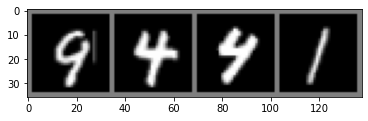

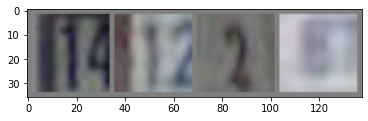

In [7]:
data_loader_X_sample = torch.utils.data.DataLoader(train_X_set,
                                                 batch_size=4, 
                                                 shuffle=True)
data_loader_Y_sample = torch.utils.data.DataLoader(train_Y_set,
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
X = next(iter(data_loader_X_sample))
Y = next(iter(data_loader_Y_sample))

# Make a grid from batch
out_X = torchvision.utils.make_grid(X[0])
out_Y = torchvision.utils.make_grid(Y[0])

imshow(out_X)
imshow(out_Y)

### Utils 
* Use the below code for the convolution or the upconvolution

### *References*
[1] Zhu et al., "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", *ICCV*, 2017. <br>
[2] https://hardikbansal.github.io/CycleGANBlog/ <br>
[3] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010. <br>
[4] Ioffe & Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", *ICML* 2015.

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

def transpose(ndarray):
    return np.transpose(ndarray, [0,2,3,1])

def gray2rgb(ndarray):
    return np.concatenate((ndarray, ndarray, ndarray), axis=2)

### 2.1 Write the code (Generator) [3 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [9]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_g_enc_X = [[1, 64, 7, 2, 3, 'LeakyReLU'], [64, 128, 3, 2, 1, 'LeakyReLU']]
cfg_g_enc_Y = [[3, 64, 7, 2, 3, 'LeakyReLU'], [64, 128, 3, 2, 1, 'LeakyReLU']]
cfg_g_trans = [128, 128, 3, 1, 1, 'LeakyReLU']
cfg_g_dec_X = [[128, 64, 4, 2, 1, 'LeakyReLU'], [64, 3, 4, 2, 1, 'Tanh']]
cfg_g_dec_Y = [[128, 64, 4, 2, 1, 'LeakyReLU'], [64, 1, 4, 2, 1, 'Tanh']]


class Generator_X(nn.Module):
    def __init__(self):
        super(Generator_X, self).__init__()
        
        #############
        # Encoder
        self.conv = nn.Sequential(
            conv2d(cfg_g_enc_X[0], batch_norm=False),
            conv2d(cfg_g_enc_X[1])
        )
        # Transformer
        self.trans = conv2d(cfg_g_trans)
        # Decoder
        self.deconv = nn.Sequential(
            upconv2d(cfg_g_dec_X[0]),
            upconv2d(cfg_g_dec_X[1], batch_norm=False)
        )
        #############
        
    def forward(self, x):
        
        #############
        x = self.conv(x)
        x = self.trans(x) + x
        x = self.trans(x) + x
        x = self.trans(x) + x
        x = self.deconv(x)
        
        return x
        #############
    
class Generator_Y(nn.Module):
    def __init__(self):
        super(Generator_Y, self).__init__()
        
        #############
        # Encoder
        self.conv = nn.Sequential(
            conv2d(cfg_g_enc_Y[0], batch_norm=False),
            conv2d(cfg_g_enc_Y[1])
        )
        # Transformer
        self.trans = conv2d(cfg_g_trans)
        # Decoder
        self.deconv = nn.Sequential(
            upconv2d(cfg_g_dec_Y[0]),
            upconv2d(cfg_g_dec_Y[1], batch_norm=False)
        )
        #############
        
        
    def forward(self, x):
        
        #############
        x = self.conv(x)
        x = self.trans(x) + x
        x = self.trans(x) + x
        x = self.trans(x) + x
        x = self.deconv(x)
        
        return x
        #############  
        

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [3 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [10]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_d_X = [[1, 64, 4, 2, 3, 'leakyrelu'], [64, 128, 4, 2, 1, 'leakyrelu'], [128, 256, 4, 1, 1, 'leakyrelu'], [256, 1, 1, 1, 0, 'sigmoid']]
cfg_d_Y = [[3, 64, 4, 2, 3, 'leakyrelu'], [64, 128, 4, 2, 1, 'leakyrelu'], [128, 256, 4, 1, 1, 'leakyrelu'], [256, 1, 1, 1, 0, 'sigmoid']]


class Discriminator_X(nn.Module):
    def __init__(self):
        super(Discriminator_X, self).__init__()
        
        #############
        self.conv = nn.Sequential(
            conv2d(cfg_d_X[0], batch_norm=False),
            conv2d(cfg_d_X[1]),
            conv2d(cfg_d_X[2]),
            conv2d(cfg_d_X[3], batch_norm=False)
        )
        #############
        
    def forward(self, x):
        
        #############
        return self.conv(x)
        #############
    
class Discriminator_Y(nn.Module):
    def __init__(self):
        super(Discriminator_Y, self).__init__()
        
        #############
        self.conv = nn.Sequential(
            conv2d(cfg_d_Y[0], batch_norm=False),
            conv2d(cfg_d_Y[1]),
            conv2d(cfg_d_Y[2]),
            conv2d(cfg_d_Y[3], batch_norm=False)
        )
        #############
        
    def forward(self, x):
        
        #############
        return self.conv(x)
        #############
        

STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G_X = Generator_X()
model_G_Y = Generator_Y()
model_D_X = Discriminator_X()
model_D_Y = Discriminator_Y()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G_X.to(device)
print(model_G_X)
model_G_Y.to(device)
print(model_G_Y)
model_D_X.to(device)
print(model_D_X)
model_D_Y.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator_X(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (trans): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (deconv): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Discriminator_Y(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Sigmoid()
    )
  )
)

In [12]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G_X = torch.optim.Adam(model_G_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_Y = torch.optim.Adam(model_G_Y.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = torch.optim.Adam(model_D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = torch.optim.Adam(model_D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the Cycle GAN [4 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
it[0100/4685] 	Loss_D:2.6211 	Loss_G:1.5434 	Loss_C:0.3266 	elapsed_time:0.30mins
it[0200/4685] 	Loss_D:2.5357 	Loss_G:1.5929 	Loss_C:0.2634 	elapsed_time:0.59mins
it[0300/4685] 	Loss_D:2.5031 	Loss_G:1.6316 	Loss_C:0.2464 	elapsed_time:0.86mins
it[0400/4685] 	Loss_D:2.5317 	Loss_G:1.6427 	Loss_C:0.2581 	elapsed_time:1.12mins
it[0500/4685] 	Loss_D:2.5588 	Loss_G:1.7035 	Loss_C:0.2507 	elapsed_time:1.40mins
it[0600/4685] 	Loss_D:2.4505 	Loss_G:1.6869 	Loss_C:0.2501 	elapsed_time:1.66mins
it[0700/4685] 	Loss_D:2.4656 	Loss_G:1.7667 	Loss_C:0.2666 	elapsed_time:1.93mins
it[0800/4685] 	Loss_D:2.4445 	Loss_G:1.8135 	Loss_C:0.2747 	elapsed_time:2.20mins
it[0900/4685] 	Loss_D:2.3624 	Loss_G:1.8626 	Loss_C:0.2795 	elapsed_time:2.47mins
it[1000/4685] 	Loss_D:2.3718 	Loss_G:1.8159 	Loss_C:0.2850 	elapsed_time:2.74mins


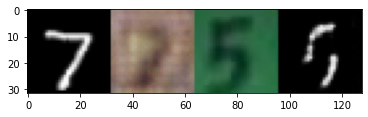

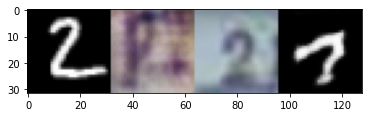

it[1100/4685] 	Loss_D:2.1901 	Loss_G:2.0156 	Loss_C:0.2883 	elapsed_time:3.04mins
it[1200/4685] 	Loss_D:2.2832 	Loss_G:2.0386 	Loss_C:0.3087 	elapsed_time:3.32mins
it[1300/4685] 	Loss_D:2.0485 	Loss_G:2.3328 	Loss_C:0.3052 	elapsed_time:3.59mins
it[1400/4685] 	Loss_D:2.1692 	Loss_G:1.8875 	Loss_C:0.3206 	elapsed_time:3.86mins
it[1500/4685] 	Loss_D:2.1382 	Loss_G:2.1592 	Loss_C:0.3443 	elapsed_time:4.13mins
it[1600/4685] 	Loss_D:2.0191 	Loss_G:2.0833 	Loss_C:0.3331 	elapsed_time:4.41mins
it[1700/4685] 	Loss_D:2.1239 	Loss_G:2.0885 	Loss_C:0.3163 	elapsed_time:4.69mins
it[1800/4685] 	Loss_D:1.9902 	Loss_G:2.2743 	Loss_C:0.3482 	elapsed_time:4.96mins
it[1900/4685] 	Loss_D:2.0599 	Loss_G:2.3381 	Loss_C:0.3363 	elapsed_time:5.23mins
it[2000/4685] 	Loss_D:2.1089 	Loss_G:2.3291 	Loss_C:0.3453 	elapsed_time:5.51mins


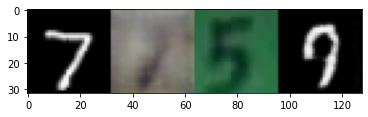

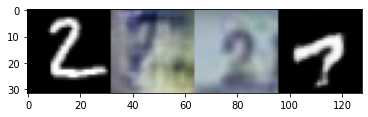

it[2100/4685] 	Loss_D:2.0468 	Loss_G:2.4447 	Loss_C:0.3406 	elapsed_time:5.81mins
it[2200/4685] 	Loss_D:1.8416 	Loss_G:2.2478 	Loss_C:0.3616 	elapsed_time:6.08mins
it[2300/4685] 	Loss_D:2.0584 	Loss_G:2.3236 	Loss_C:0.3467 	elapsed_time:6.35mins
it[2400/4685] 	Loss_D:1.9545 	Loss_G:2.2073 	Loss_C:0.3275 	elapsed_time:6.62mins
it[2500/4685] 	Loss_D:1.7454 	Loss_G:2.3608 	Loss_C:0.3323 	elapsed_time:6.89mins
it[2600/4685] 	Loss_D:1.9504 	Loss_G:2.2830 	Loss_C:0.3382 	elapsed_time:7.16mins
it[2700/4685] 	Loss_D:2.0470 	Loss_G:2.1471 	Loss_C:0.3602 	elapsed_time:7.43mins
it[2800/4685] 	Loss_D:2.2208 	Loss_G:2.2191 	Loss_C:0.3546 	elapsed_time:7.71mins
it[2900/4685] 	Loss_D:1.8982 	Loss_G:2.5190 	Loss_C:0.3564 	elapsed_time:7.98mins
it[3000/4685] 	Loss_D:1.8078 	Loss_G:2.6142 	Loss_C:0.3666 	elapsed_time:8.25mins


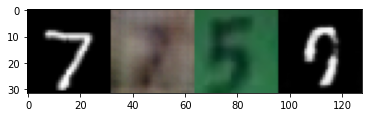

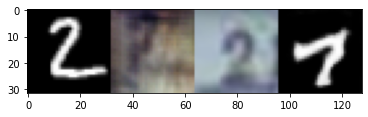

it[3100/4685] 	Loss_D:2.0132 	Loss_G:2.2003 	Loss_C:0.3761 	elapsed_time:8.55mins
it[3200/4685] 	Loss_D:1.9831 	Loss_G:2.3031 	Loss_C:0.3647 	elapsed_time:8.82mins
it[3300/4685] 	Loss_D:1.9519 	Loss_G:2.6812 	Loss_C:0.3574 	elapsed_time:9.09mins
it[3400/4685] 	Loss_D:1.6652 	Loss_G:2.5917 	Loss_C:0.3385 	elapsed_time:9.36mins
it[3500/4685] 	Loss_D:2.1833 	Loss_G:2.5872 	Loss_C:0.3563 	elapsed_time:9.63mins
it[3600/4685] 	Loss_D:1.7301 	Loss_G:2.5534 	Loss_C:0.3324 	elapsed_time:9.90mins
it[3700/4685] 	Loss_D:1.7636 	Loss_G:2.5880 	Loss_C:0.3585 	elapsed_time:10.17mins
it[3800/4685] 	Loss_D:1.7132 	Loss_G:2.2311 	Loss_C:0.3409 	elapsed_time:10.45mins
it[3900/4685] 	Loss_D:1.8563 	Loss_G:2.9210 	Loss_C:0.3423 	elapsed_time:10.72mins
it[4000/4685] 	Loss_D:1.7696 	Loss_G:2.3598 	Loss_C:0.3251 	elapsed_time:10.99mins


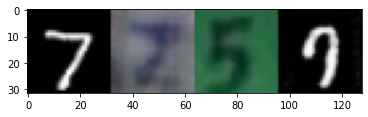

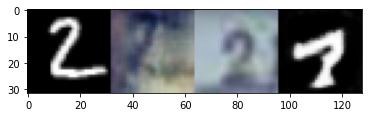

it[4100/4685] 	Loss_D:1.8152 	Loss_G:2.1879 	Loss_C:0.3707 	elapsed_time:11.29mins
it[4200/4685] 	Loss_D:2.0650 	Loss_G:2.3018 	Loss_C:0.3323 	elapsed_time:11.56mins
it[4300/4685] 	Loss_D:1.8820 	Loss_G:2.5828 	Loss_C:0.3763 	elapsed_time:11.83mins
it[4400/4685] 	Loss_D:1.5499 	Loss_G:3.0547 	Loss_C:0.3758 	elapsed_time:12.10mins
it[4500/4685] 	Loss_D:1.8954 	Loss_G:2.5939 	Loss_C:0.3559 	elapsed_time:12.37mins
it[4600/4685] 	Loss_D:1.6662 	Loss_G:2.8375 	Loss_C:0.3558 	elapsed_time:12.64mins


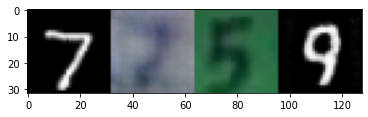

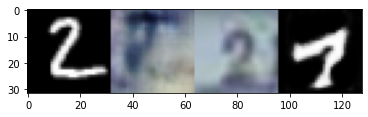

In [13]:
print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs, 1, 8, 8), real_label, dtype=torch.float32, device=device)
label_fake = torch.full((bs, 1, 8, 8), fake_label, dtype=torch.float32, device=device)

num_iter = 0
max_iter = num_epochs*len(train_X_loader)

train_start_time = time.time()
for epoch in range(1, num_epochs+1):
    for batch_index, data_X in enumerate(train_X_loader):
        model_G_X.train()
        model_G_Y.train()
        model_D_X.train()
        model_D_Y.train()
        
        data_X = data_X[0].to(device)
        data_Y = next(iter(train_Y_loader))[0].to(device)
        
        ### Update discriminator model
        # Clear gradients w.r.t. parameters
        model_D_Y.zero_grad()
        model_D_X.zero_grad()
        
        # for D_Y
        # Forward pass to get results of discriminator for real data
        output_D_Y_real = model_D_Y(data_Y)
        
        # Calculate Loss
        err_D_Y_real = criterion_GAN(output_D_Y_real, label_real)
        
        # Forward pass to get generated samples
        fake_Y = model_G_X(data_X)
        
        # Forward pass to get results of discriminator for fake data
        output_D_Y_fake = model_D_Y(fake_Y.detach())
        
        # Calculate Los
        err_D_Y_fake = criterion_GAN(output_D_Y_fake, label_fake)
        
        # for D_X
        output_D_X_real = model_D_X(data_X)
        err_D_X_real = criterion_GAN(output_D_X_real, label_real)
        fake_X = model_G_Y(data_Y)
        output_D_X_fake = model_D_X(fake_X.detach())
        err_D_X_fake = criterion_GAN(output_D_X_fake, label_fake)
        
        # # Combine the losses for real data and fake data
        err_D = err_D_X_real + err_D_Y_real + err_D_X_fake + err_D_Y_fake
        
        # Getting gradients w.r.t. parameters
        err_D.backward()
        
        # Updating parameters
        optimizer_D_X.step()
        optimizer_D_Y.step()

        ### Update generator model
        
        # Clear gradients w.r.t. parameters
        model_G_X.zero_grad()
        model_G_Y.zero_grad()
        
        output_G_Y_gen = model_D_X(fake_X)
        output_G_X_gen = model_D_Y(fake_Y)
        
        # Calculate Loss
        err_G_X = criterion_GAN(output_G_X_gen, label_real)
        err_G_Y = criterion_GAN(output_G_Y_gen, label_real)
        err_G = err_G_X + err_G_Y
        
        # Computing L1 loss
        err_C_X = criterion_L1(model_G_Y(fake_Y), data_X)
        err_C_Y = criterion_L1(model_G_X(fake_X), data_Y)
        err_C = err_C_X + err_C_Y
        
        err_G_C = err_G + err_C
        
        # Getting gradients w.r.t. parameters
        err_G_C.backward()
        
        # Updating parameters
        optimizer_G_X.step()
        optimizer_G_Y.step()
        

        num_iter += 1
        # Output training stats
        if num_iter%100 == 0:
            print('it[{:04d}/{:04d}] \tLoss_D:{:.4f} \tLoss_G:{:.4f} \tLoss_C:{:.4f} \telapsed_time:{:.2f}mins'.format(
                num_iter, max_iter, err_D.item(), err_G.item(), err_C.item(), (time.time()-train_start_time)/60 
            ))

        if num_iter%1000==0 or num_iter==max_iter:
            save_name = osp.join(save_dir, 'it{:04d}.pt'.format(num_iter))
            torch.save({
                'model_G_X': model_G_X.state_dict(),
                'model_G_Y': model_G_Y.state_dict()
            }, save_name)
    
            with torch.no_grad():
                model_G_X.eval()
                model_G_Y.eval()
                for test_index, data_X in enumerate(test_X_loader):
                    if test_index == 0:
                        
                        data_X = data_X[0].to(device)
                        data_Y = next(iter(test_Y_loader))[0].to(device)

                        output_X = model_G_X(data_X)
                        output_Y = model_G_Y(data_Y)
                        
                        data_X = ((data_X+1)/2).cpu().data.numpy()
                        data_Y = ((data_Y+1)/2).cpu().data.numpy()

                        output_X = ((output_X + 1)/2).cpu().data.numpy()
                        output_Y = ((output_Y + 1)/2).cpu().data.numpy()
                
                        for vis_idx in range(vis_num):
                            data_X_, data_Y_ = gray2rgb(transpose(data_X)[vis_idx]), transpose(data_Y)[vis_idx]
                            output_X_, output_Y_  = transpose(output_X)[vis_idx], gray2rgb(transpose(output_Y)[vis_idx])
                            outputs = np.concatenate((data_X_, output_X_, data_Y_, output_Y_), axis=1)
                            plt.imshow(outputs)
                            plt.pause(0.001)

Model각 layer의 padding값을 input과 output의 resolution을 고려하여 맞추는 것은 어렵지 않지만,
padding을 잘 설정하는 것이 결과에 영향을 미치기 때문에 주의하여 설정해야 했다.

실험적으로 확인하였을 떄, forward에서 padding의 크기는 layer의 처음부분과 kernel size가 큰 경우에
padding size를 크게하고 그외에 작게 하는 것이 시각적으로 더 보기 좋은 결과를 보여주었다.